In [72]:
#Dependencies
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader
import itertools
import torch

import os

import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares

import os 

from collections import defaultdict
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchtools.optim import Ranger
from ranger import Ranger

import tqdm
import random
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity as cs
import seaborn as sns

## 1. 데이터 불러오기

In [73]:
datapath = os.getenv('HOME') + '/project/thebest_52/data/data_final.csv'
columns =  ['item', 'user', 'rating', 'timestamp']
df = pd.read_csv(datapath, sep = ",", names = columns, dtype = int)
df.astype(int)
df.head()

,item,user,rating,timestamp
0,122,3094405,5,1112140800
1,122,14877871,5,1466380800
2,122,7151803,5,1436400000
3,122,10069097,5,1383436800
4,122,13327705,5,1357084800


In [74]:
users_df = df.sort_values(["user","timestamp"]).set_index("user").fillna(0).drop("timestamp",axis=1)
users = dict(tuple(df.groupby("user")))

In [75]:
print(df.shape)

(13361842, 4)


In [76]:
df['user'].nunique()

258582

In [77]:
df['item'].nunique()

637911

In [78]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = df['user'].unique()
item_unique = df['item'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
idx_to_user = {k:v for k,v in enumerate(user_unique)}
item_to_idx = {v:k for k,v in enumerate(item_unique)}
idx_to_item = {k:v for k,v in enumerate(item_unique)}

In [79]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df['user'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('userId column indexing OK!!')
    df['user'] = temp_user_data   # data['userId']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('userId column indexing Fail!!')

# movie_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_item_data = df['item'].map(item_to_idx.get).dropna()
if len(temp_item_data) == len(df):
    print('itemId column indexing OK!!')
    df['item'] = temp_item_data
else:
    print('itemId column indexing Fail!!')
# up_data

userId column indexing OK!!
itemId column indexing OK!!


In [80]:
num_user = df['user'].nunique()
num_item = df['item'].nunique()

csr_data = csr_matrix((df['rating'], (df.user, df.item)), shape= (num_user, num_item))

In [81]:
#num_threads=-1
als_model = AlternatingLeastSquares(factors=100, regularization=0.01,use_gpu=False,
                                    iterations=15,dtype=np.float32,calculate_training_loss=True, num_threads=1)

#item x user
csr_data_transpose = csr_data.T
# csr_data_transpose
als_model.fit(csr_data_transpose)

In [82]:
item_embeddings_dict = {idx_to_item[i]:tf.convert_to_tensor(als_model.item_factors[i]) for i in tqdm.tqdm(range(num_item))}
user_embeddings_dict = {idx_to_user[i]:tf.convert_to_tensor(als_model.user_factors[i]) for i in tqdm.tqdm(range(num_user))}

len(user_embeddings_dict)

100%|██████████| 258582/258582 [00:01<00:00, 166623.65it/s]


258582

In [83]:
len(item_embeddings_dict)

637911

## 2. Train and Test Dataset

In [84]:
#Getting users with positive rating count greater than 10
# 10 == 'N' positively interacted items
# from collections import defaultdict
# from collections import Counter
users_dict = defaultdict(dict)
users_id_list = set()
for user_id in users:
#   rating_freq = Counter(users[user_id]["Rating"].values)
#   if rating_freq['4']+rating_freq['5']<10 :
#     continue    
#   else:
    users_id_list.add(int(user_id))
    users_dict[user_id]["item"] = users[user_id]["item"].values
    users_dict[user_id]["rating"] = users[user_id]["rating"].values

In [85]:
users_id_list = np.array(list(users_id_list))
print(users_id_list)

[12058627 14680070  7340040 ...  9437172 12058615 11010043]


In [86]:
len(users_id_list)

258582

In [87]:
#choosing default train_test_split of 25%
train_users,test_users = train_test_split(users_id_list)
print(train_users[:2])

[9729824 2920182]


In [88]:
print(test_users[:2])

[ 1462628 13101903]


In [89]:
from torch.utils.data import Dataset
class UserDataset(Dataset):
    def __init__(self,users_list,users_dict):
        self.users_list = users_list
        self.users_dict = users_dict

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self,idx):
        user_id = self.users_list[idx]
        items = [('1',)]*10
        ratings = [('0',)]*10
        j=0
        for i,rate in enumerate(self.users_dict[user_id]["rating"]):
            if int(rate) >3 and j < 10:
                items[j] = self.users_dict[user_id]["item"][i]
                ratings[j] = self.users_dict[user_id]["rating"][i]
                j += 1
        # item = list(self.users_dict[user_id]["item"][:])
        # rating = list(self.users_dict[user_id]["rating"][:])
        size = len(items)
    
        return {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}

In [90]:
train_users_dataset = UserDataset(train_users,users_dict)
test_users_dataset = UserDataset(test_users,users_dict)

In [91]:
train_dataloader = DataLoader(train_users_dataset,batch_size=1)
test_dataloader = DataLoader(test_users_dataset,batch_size=1)

In [92]:
train_num = len(train_dataloader)
print(train_num)

193936


## 3. State Representation Models¶

### DDR-ave

In [93]:
def drrave_state_rep(userid_b,items,memory,idx):
    user_num = idx
    H = [] #item embeddings
    user_n_items = items
    user_embeddings = torch.Tensor(np.array(user_embeddings_dict[userid_b[0]]),).unsqueeze(0)
    for i,item in enumerate(user_n_items):
        H.append(np.array(item_embeddings_dict[item[0]]))
    avg_layer = nn.AvgPool1d(1)  # pooling layer 사용 
    item_embeddings = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    state = torch.cat([user_embeddings,user_embeddings*item_embeddings.T,item_embeddings.T])
    return state #state tensor shape [21,100]

### DDR-u

In [94]:
# def drru_state_rep(userid_b,items,memory,idx):
#     user_num = idx
#     H = []
#     user_n_items = items
#     user_embeddings = user_embeddings_dict[userid_b[0]]
#     for i,item in enumerate(user_n_items):
#         ui = np.array(user_embeddings) * np.array(movie_embeddings_dict[item[0]])
#         H.append(ui)

#     pairs = list(itertools.combinations(memory[user_num], 2))
#     for item1,item2 in pairs:
#         pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#         pair2 = np.array(movie_embeddings_dict[str(int(item2))])

#         product = pair1*pair2
#         H.append(product)
#     state = torch.Tensor(H,)
#     return state #state tensor shape [55,100]


### DDR-p

In [95]:
# def drrp_state_rep(items,memory,idx):
#   user_num = idx
#   H = []
#   user_n_items = items
#   for i,item in enumerate(user_n_items):
#     H.append(np.array(movie_embeddings_dict[item[0]]))
  
#   pairs = list(itertools.combinations(memory[user_num], 2))
#   for item1,item2 in pairs:
#     pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#     pair2 = np.array(movie_embeddings_dict[str(int(item2))])
#     product = pair1*pair2
#     H.append(product)
#   state = torch.Tensor(H,)
#   return state

### state-rep

In [96]:
# just n items and their embeddings used to represent state
def state_rep(item_b):
    state = []
    user_embeddings = np.zeros((len(columns),100))
    item_ids = list(item[0] for item in item_b)
    for i,subitem in enumerate(user_embeddings):
        if idx_to_id[i] in item_ids:
            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])
        else:
            user_embeddings[i] = np.zeros((100,))
    state = torch.Tensor(user_embeddings,)
    return torch.reshape(state,[-1]) 

## 4. Actor, Critic 

In [97]:
!pip install git+https://github.com/pabloppp/pytorch-tools@0.2.4 -U

  Cloning https://github.com/pabloppp/pytorch-tools (to revision 0.2.4) to /tmp/pip-req-build-_h27vkm5
  Running command git clone -q https://github.com/pabloppp/pytorch-tools /tmp/pip-req-build-_h27vkm5
  Running command git checkout -q 86c73996537002ab29e7e40f925cb90756f58156
  Created wheel for torchtools: filename=torchtools-0.2.4-py3-none-any.whl size=19202 sha256=744adfd2f4257bcc4b5c0fc49c7861e3bad4b28c5c2e69f7d7e0f12f2f4441af
  Stored in directory: /tmp/pip-ephem-wheel-cache-1txk83zf/wheels/e9/db/08/ceb66f88d5c31d39af6901601b4b9084b365c3b484105ee2f5
Successfully built torchtools
  Attempting uninstall: torchtools
    Found existing installation: torchtools 0.2.4
    Uninstalling torchtools-0.2.4:
      Successfully uninstalled torchtools-0.2.4


In [98]:
#Actor Model:
#Generating an action a based on state s

class Actor(torch.nn.Module):
    def __init__(self, input_dim, output_dim,hidden_dim):
        super(Actor, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        # print(x.shape)
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        # print(x.shape)
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x # state = self.state_rep(state)
   

In [99]:
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim):

        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
    
        self.linear1 = nn.Linear(input_dim + output_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self,state,action):    
        x = torch.cat([state, action], 1)
        # print(x.shape)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [100]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # print(batch)
        state, action, reward, next_state = map(np.stack,zip(*batch))
        return state, action, reward, next_state
    
    def __len__(self):
        return len(self.buffer)

In [101]:
device = 'cpu'
# cuda = torch.device('cuda')

In [102]:
#used for plotting purposes
p_loss = []
v_loss = []

In [103]:
def ddpg_update(batch_size=1, 
                gamma = 0.6,
                min_value=-np.inf,
                max_value=np.inf,
                soft_tau=1e-2):
    
    state, action, reward, next_state = replay_buffer.sample(batch_size)
    state      = torch.FloatTensor(state).to(device)

    next_state = torch.FloatTensor(next_state).to(device)

    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    # print(state.shape)
    # print(policy_net(state).shape)
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()
    p_loss.append(policy_loss)
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    # print("1")
    value_loss = value_criterion(value, expected_value.detach())
    # print("2")
    v_loss.append(value_loss)
    policy_optimizer.zero_grad()
    # print("3")
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [104]:
#initializing actor and critic networks for drru and drrp state representation

value_net = Critic(5500,100,256)
policy_net = Actor(5500,100,256)

target_value_net = Critic(5500,100,256)
target_policy_net = Actor(5500,100,256)


target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [105]:
#initializing for drrave state representation

value_net = Critic(2100,100,256)
policy_net = Actor(2100,100,256)

target_value_net = Critic(2100,100,256)
target_policy_net = Actor(2100,100,256)


target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [106]:
print(policy_net)

Actor(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2100, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=100, bias=True)
)


In [107]:
replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

memory = np.ones((train_num,10))*-1

In [108]:
def get_action(state,action_emb,userid_b,item_b,preds):
    action_emb = torch.reshape(action_emb,[1,100]).unsqueeze(0)
    item_embedding = []
    for item in users_dict[userid_b[0]]["item"]:  
        item_embedding.append(np.array(item_embeddings_dict[item]))
    item_embedding = torch.Tensor(item_embedding,)
    items = item_embedding.T.unsqueeze(0)
    m = torch.bmm(action_emb,items).squeeze(0)  #torch.bmm : batch 행렬 곱연산
    sorted_m,indices = torch.sort(m,descending=True)
    index_list = list(indices[0])
    for i in index_list:
        if users_dict[userid_b[0]]["item"][i] not in preds:    
            preds.add(users_dict[userid_b[0]]["item"][i])
            return int(i)

In [109]:
def update_memory(memory,action,idx):
    memory[idx] = list(memory[idx,1:])+[action]

In [110]:
rate = 0

## 5. Training

In [71]:
preddict = dict()
it = iter(train_dataloader)
for episode in tqdm.tqdm(range(train_num-1)):    
    batch_size= 1
    preds = set()
    first = next(it)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    for j in range(5):    
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)
        action = get_action(state,action_emb,userid_b,item_b,preds)
        rate = int(users_dict[userid_b[0]]["rating"][action])
        try:
            ratings = (int(rate)-3)/2
        except:
            ratings = 0
        reward = torch.Tensor((ratings,))

        if reward > 0:
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)

        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        next_state_rep = torch.reshape(next_state,[-1])
        replay_buffer.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy())
        if len(replay_buffer) > batch_size:
            ddpg_update()

        state = next_state
    preddict[userid_b[0]] = preds

  0%|          | 0/193935 [00:00<?, ?it/s]


KeyError: tensor(10525199)

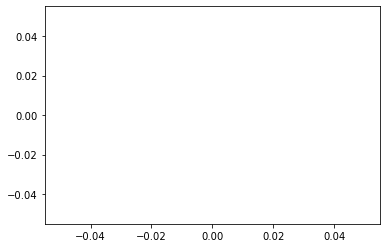

In [55]:
plt.plot(v_loss)

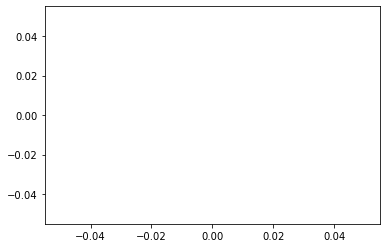

In [56]:
plt.plot(p_loss)

## 6. Testing

In [58]:
#Getting Cosine similarity of recommended items for a particular userid that has been evaluated
# from sklearn.metrics.pairwise import cosine_similarity as cs
# import seaborn as sns

def get_cosine_sim(userid):
    test_pred = test_pred_dict[userid]
    for i,item in enumerate(users_dict[userid]["item"]):
        if item in test_pred:
            print(item,":",users_dict[userid]["rating"][i])

    test_embed = []
    for item in test_pred:
        test_embed.append(np.array(item_embeddings_dict[item]))

    test_embed_array = np.array(test_embed)

    return test_embed_array

test_embed_array = get_cosine_sim(userid_b[0])
ax = sns.heatmap(cs(test_embed_array), linewidth=0.5)
plt.show()


NameError: name 'test_pred_dict' is not defined

In [59]:
#prediction algorithm
it2 = iter(test_dataloader)
precision = 0
test_pred_dict = dict()
for j in range(len(test_dataloader)-1):  #session 돌리기 : timestamps 내에서 items들 
    first = next(it2)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    count = 0
    test_pred = set()
    for j in range(5):  #policy network5번 돌리기 , 추천 5번 하기
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)   # policy_net = actor : items들의 선호도 (rating)
        action = get_action(state,action_emb,userid_b,item_b,test_pred)
        rate = int(users_dict[userid_b[0]]["rating"][action])
        try:
            rating = (int(rate)-3)/2
        except:
            rating = 0
        reward = torch.Tensor((rating,))

        if reward > 0:
            count += 1
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        state = next_state
    precision += count/5
    test_pred_dict[userid_b[0]] = test_pred
print("p",precision/(len(test_dataloader)-1))

KeyError: tensor(6439906)

## 7. Saving and Loading Models

In [60]:
PATH = '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'
torch.save(policy_net.state_dict(), PATH)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'

In [61]:
value_PATH = '/content/gdrive/My Drive/RLProject/Models/drravevalue_net.pth'
torch.save(value_net.state_dict(), value_PATH)

tpolicy_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetpolicy_net.pth'
torch.save(target_policy_net.state_dict(), tpolicy_PATH)

tvalue_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetvalue_net.pth'
torch.save(target_value_net.state_dict(), tvalue_PATH)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/RLProject/Models/drravevalue_net.pth'

In [62]:
np.save('/content/gdrive/My Drive/RLProject/Models/train_dataloader',train_dataloader)
np.save('/content/gdrive/My Drive/RLProject/Models/test_dataloader',test_dataloader)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/RLProject/Models/train_dataloader.npy'

In [63]:
policy_net = Actor(5500,100,256)
policy_net.load_state_dict(torch.load(PATH))
policy_net.eval()

value_net = Critic(5500,100,256)
value_net.load_state_dict(torch.load(value_PATH))
value_net.eval()

target_policy_net = Actor(5500,100,256)
target_policy_net.load_state_dict(torch.load(tpolicy_PATH))
target_policy_net.eval()

target_value_net = Critic(5500,100,256)
target_value_net.load_state_dict(torch.load(tvalue_PATH))
target_value_net.eval()


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'

In [64]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

train_data = np.load('/content/gdrive/My Drive/RLProject/Models/train_users.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/RLProject/Models/train_users.npy'

In [65]:
np.load = np_load_old